# Prepoznavanje vozne trake

## Algoritam se sastoji od 2 glavna dijela:
### 1. Obrada slike koja za rezultat daje binarnu sliku koja predstavlja masku voznih traka
### Korak 1: Kalibracija kamere
### Korak 2: Označavanje ROI-a (Region of Interes) i obavljanje perspektivne transformacije na ROI
### Korak 3: Obrada slike unutar ROI
### 2. Obrada binarne slike nakon koje dobijemo dva pravca koja predstavljaju vozne trake
### Korak 4: Izračun histograma po x osi kako bismo odredili najveću koncentraciju bijelih piksela (binarnih jedinica) na slici
###

# 1. Obrada slike koja za rezultat daje binarnu sliku koja predstavlja masku voznih traka

Uključivanje biblioteka

In [1]:
import numpy as np
import cv2
import pickle
import glob
import matplotlib.pyplot as plt
print('Imports done')

Imports done


## Korak 1: Kalibracija kamere 
## U ovom koraku se uklanja distorzija (zaobljenje) slike uzrokovano fizičkom lećom na kameri

Original Image


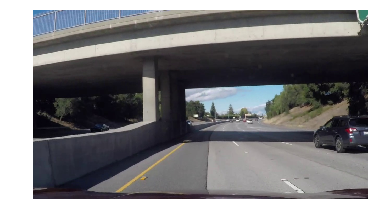

In [2]:
#exampleImg = cv2.imread('./Test_images/dashcam_driving/frame117.jpg')
exampleImg = cv2.imread('./Test_images/challnege_video/frame117.jpg')
exampleImg = cv2.cvtColor(exampleImg, cv2.COLOR_BGR2RGB)
plt.imshow(exampleImg)
plt.axis('off')
print('Original Image')

Prikaz originalne slike

Definiranje funkcije koja vrši uklanjanje distorzije.

In [3]:
#Constants used for image undistortion, calculated in another function 
mtx = np.array([[1.15694035e+03, 0.00000000e+00, 6.65948597e+02],[0.00000000e+00, 1.15213869e+03, 3.88785178e+02],[0.00000000e+00, 0.00000000e+00, 1.00000000e+00]],np.float64)
dist = np.array([-2.37636612e-01, -8.54129776e-02, -7.90955950e-04, -1.15908700e-04, 1.05741395e-01],np.float64)


def undistort(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

Konstante su kopirane iz prethodno obavljene funkcije koja je izračunala koeficijente

## Prikaz slike nakon uklanjanja distorzije slike uzrokovano lećom na kameri

...


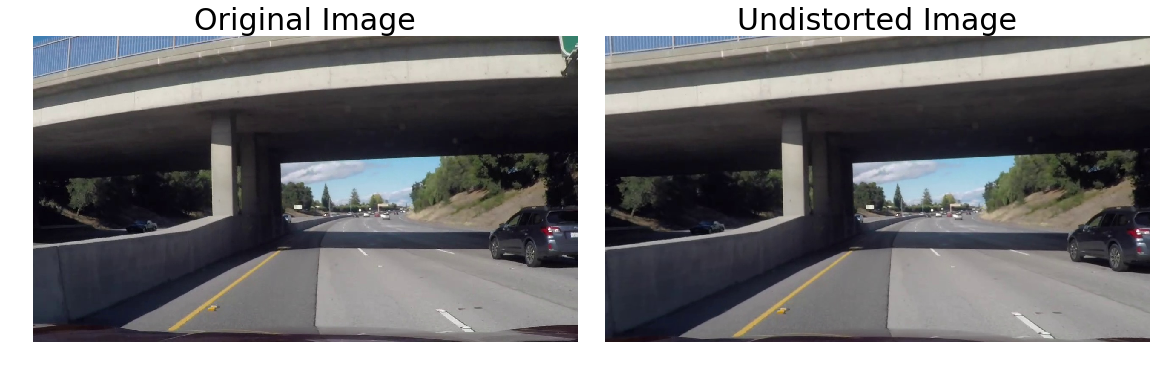

In [4]:
exampleImg_undistort = undistort(exampleImg)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)

ax1.imshow(exampleImg)
ax1.set_title('Original Image', fontsize=30)
ax1.axis('off')

ax2.imshow(exampleImg_undistort)
ax2.set_title('Undistorted Image', fontsize=30)
ax2.axis('off')
print('...')



Promjena je vidljiva na dnu slika kod haube.

# Korak 2: Označavanje ROI-a (Region of Interes) i obavljanje perspektivne transformacije na ROI

Definiranje funkcije koja vrši perspektivnu transformaciju

In [5]:
def unwarp(img, src, dst):
    h,w = img.shape[:2]
    # use cv2.getPerspectiveTransform() to get M, the transform matrix, and Minv, the inverse
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped, M, Minv
print('...')


...


src - sadrži dimenzije trapeza (koordinate 4 točke na slici) koji se uzima iz originalne slike i na kojem se vrši perspektivna transformacija.

dst - sadrži koordinate odredišnih točaka nakon transformacije. Ovdje je u pitanju kvadrat.

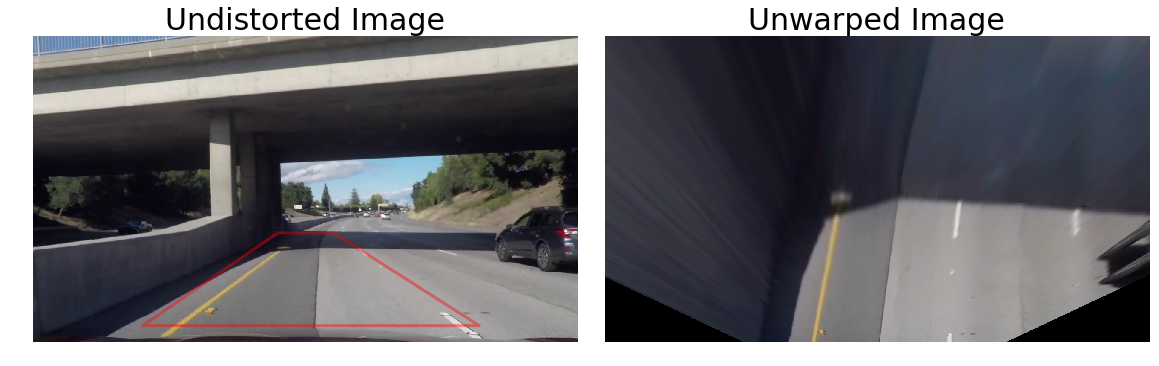

In [6]:
h,w = exampleImg_undistort.shape[:2]

src = np.float32([(575,464),
                  (707,464),
                  (258,682),
                  (1049,682)])
dst = np.float32([(450,0),
                  (w-450,0),
                  (450,h),
                  (w-450,h)])

exampleImg_unwarp, M, Minv = unwarp(exampleImg_undistort, src, dst)


# Visualize unwarp
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(exampleImg_undistort)
x = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
y = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]
ax1.plot(x, y, color='#ff0000', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
ax1.set_ylim([h,0])
ax1.set_xlim([0,w])
ax1.axis('off')
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(exampleImg_unwarp)
ax2.set_title('Unwarped Image', fontsize=30)
ax2.axis('off')

print('')

# Korak 3: Obrada slike unutar ROI

## Cilj je dobiti binarnu sliku koja prikazuje samo linije

Konverzija slike u različite colorspace-ove

...


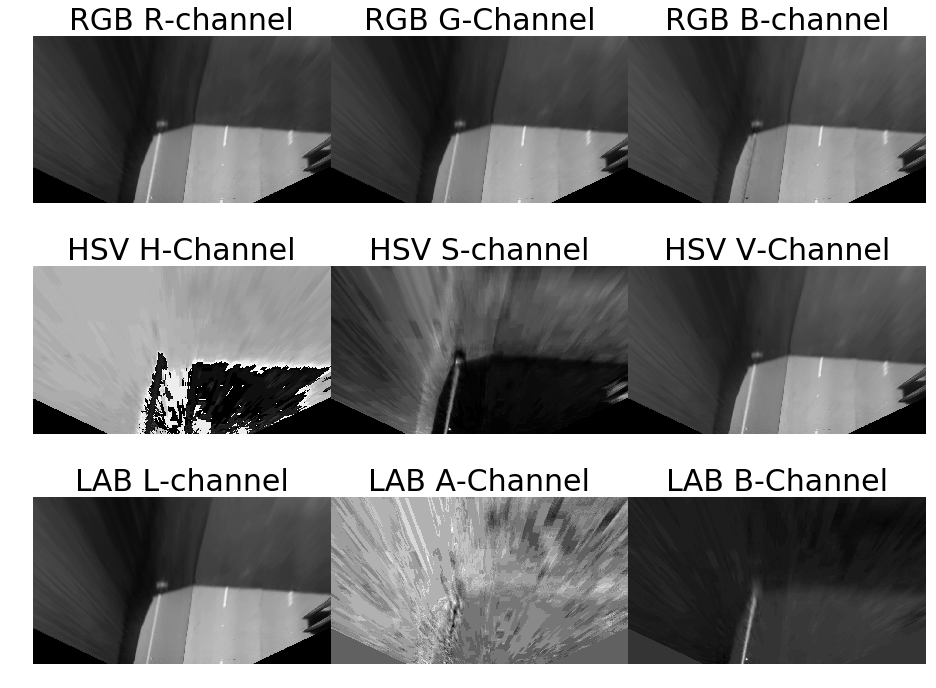

In [7]:
# Visualising multiple color space channels
exampleImg_unwarp_R = exampleImg_unwarp[:,:,0]
exampleImg_unwarp_G = exampleImg_unwarp[:,:,1]
exampleImg_unwarp_B = exampleImg_unwarp[:,:,2]
exampleImg_unwarp_HSV = cv2.cvtColor(exampleImg_unwarp, cv2.COLOR_RGB2HSV)
exampleImg_unwarp_H = exampleImg_unwarp_HSV[:,:,0]
exampleImg_unwarp_S = exampleImg_unwarp_HSV[:,:,1]
exampleImg_unwarp_V = exampleImg_unwarp_HSV[:,:,2]
exampleImg_unwarp_LAB = cv2.cvtColor(exampleImg_unwarp, cv2.COLOR_RGB2Lab)
exampleImg_unwarp_L = exampleImg_unwarp_LAB[:,:,0]
exampleImg_unwarp_A = exampleImg_unwarp_LAB[:,:,1]
exampleImg_unwarp_B2 = exampleImg_unwarp_LAB[:,:,2]

fig, axs = plt.subplots(3,3, figsize=(16, 12))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
axs[0].imshow(exampleImg_unwarp_R, cmap='gray')
axs[0].set_title('RGB R-channel', fontsize=30)
axs[0].axis('off')
axs[1].imshow(exampleImg_unwarp_G, cmap='gray')
axs[1].set_title('RGB G-Channel', fontsize=30)
axs[1].axis('off')
axs[2].imshow(exampleImg_unwarp_B, cmap='gray')
axs[2].set_title('RGB B-channel', fontsize=30)
axs[2].axis('off')
axs[3].imshow(exampleImg_unwarp_H, cmap='gray')
axs[3].set_title('HSV H-Channel', fontsize=30)
axs[3].axis('off')
axs[4].imshow(exampleImg_unwarp_S, cmap='gray')
axs[4].set_title('HSV S-channel', fontsize=30)
axs[4].axis('off')
axs[5].imshow(exampleImg_unwarp_V, cmap='gray')
axs[5].set_title('HSV V-Channel', fontsize=30)
axs[5].axis('off')
axs[6].imshow(exampleImg_unwarp_L, cmap='gray')
axs[6].set_title('LAB L-channel', fontsize=30)
axs[6].axis('off')
axs[7].imshow(exampleImg_unwarp_A, cmap='gray')
axs[7].set_title('LAB A-Channel', fontsize=30)
axs[7].axis('off')
axs[8].imshow(exampleImg_unwarp_B2, cmap='gray')
axs[8].set_title('LAB B-Channel', fontsize=30)
axs[8].axis('off')
print('...')

Definiranje funkcije za sobel threshold i ispisivanje rezultata na slici

In [8]:
# Defining a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
def abs_sobel_thresh(img, orient='x', thresh_min=25, thresh_max=255):
    # 1) Convert to grayscale === or LAB L channel
    gray = (cv2.cvtColor(img, cv2.COLOR_RGB2Lab))[:,:,0]
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    sobel = cv2.Sobel(gray, cv2.CV_64F, orient=='x', orient=='y')
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # 6) Return this mask as your binary_output image
    binary_output = sxbinary # Remove this line
    return binary_output
print('...')

...


...


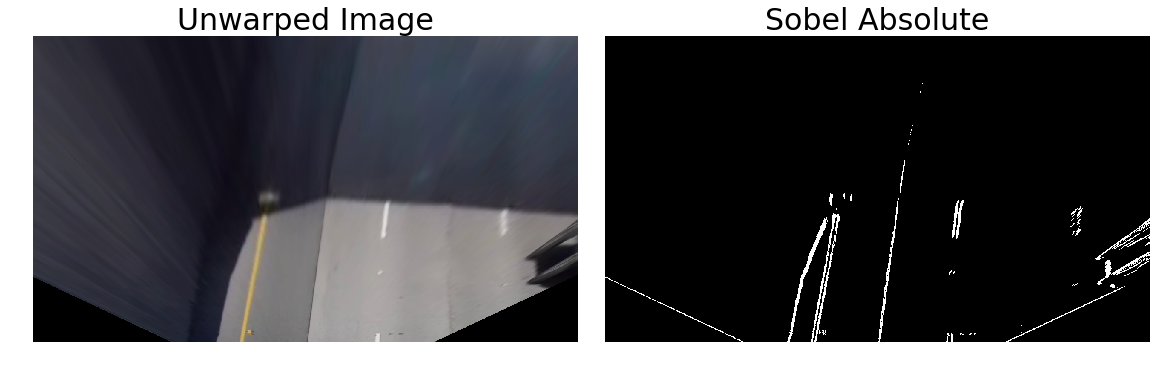

In [9]:
min_thresh=25
max_thresh=255
exampleImg_sobelAbs = abs_sobel_thresh(exampleImg_unwarp, 'x', min_thresh, max_thresh)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(exampleImg_unwarp)
ax1.set_title('Unwarped Image', fontsize=30)
ax1.axis('off')
ax2.imshow(exampleImg_sobelAbs, cmap='gray')
ax2.set_title('Sobel Absolute', fontsize=30)
ax2.axis('off')
print('...')

Definiranje funkcije za sobel magnitude i ispisivanje rezultata na slici

In [10]:
# Defining a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=25, mag_thresh=(25, 255)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Calculate the magnitude 
    mag_sobel = np.sqrt(np.square(sobelx) + np.square(sobely))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*mag_sobel/np.max(mag_sobel))
    # 5) Create a binary mask where mag thresholds are met
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    binary_output = np.copy(sxbinary) 
    return binary_output
print('...')

...


...


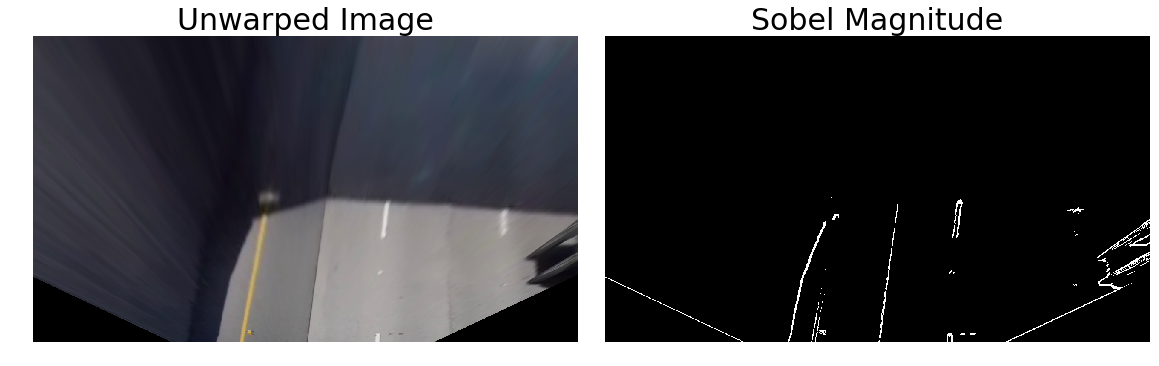

In [11]:
min_thresh=25
max_thresh=255
kernel_size=25


exampleImg_sobelMag = mag_thresh(exampleImg_unwarp, kernel_size, (min_thresh, max_thresh))
# Visualising sobel magnitude threshold
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(exampleImg_unwarp)
ax1.set_title('Unwarped Image', fontsize=30)
ax1.axis('off')
ax2.imshow(exampleImg_sobelMag, cmap='gray')
ax2.set_title('Sobel Magnitude', fontsize=30)
ax2.axis('off')
print('...')

Definiranje funkcije za sobel direction threshold i ispisivanje rezultata na slici

In [12]:
# Defining a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_thresh(img, sobel_kernel=7, thresh=(0, 0.09)):    
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output =  np.zeros_like(grad_dir)
    binary_output[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output
print('...')

...


...


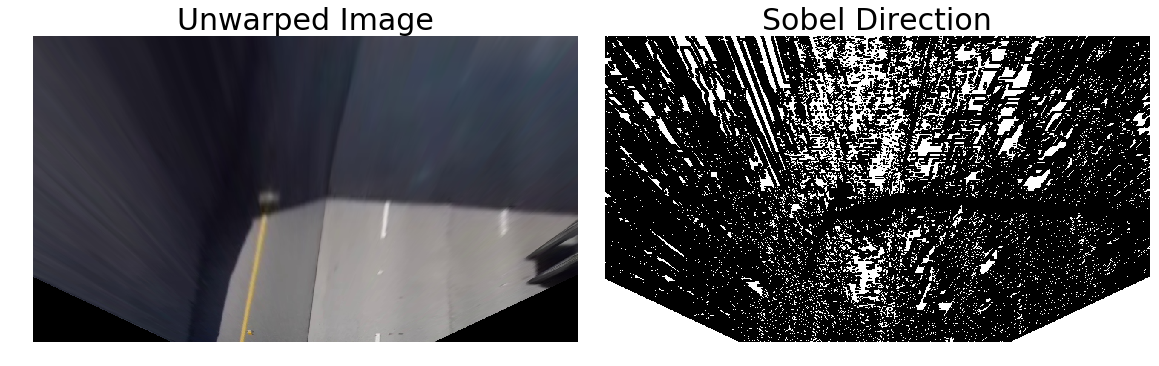

In [13]:
min_thresh=0
max_thresh=0.11
kernel_size=7

exampleImg_sobelDir = dir_thresh(exampleImg_unwarp, kernel_size, (min_thresh, max_thresh))
# Visualize sobel direction threshold
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(exampleImg_unwarp)
ax1.set_title('Unwarped Image', fontsize=30)
ax1.axis('off')
ax2.imshow(exampleImg_sobelDir, cmap='gray')
ax2.set_title('Sobel Direction', fontsize=30)
ax2.axis('off')
    
print('...')

Definiranje funkcije za HLS s-kanal threshold i ispisivanje rezultata na slici

In [14]:
# Defining a function that thresholds the S-channel of HLS
def hls_sthresh(img, thresh=(125, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    binary_output = np.zeros_like(hls[:,:,2])
    binary_output[(hls[:,:,2] > thresh[0]) & (hls[:,:,2] <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output
print('...')

...


...


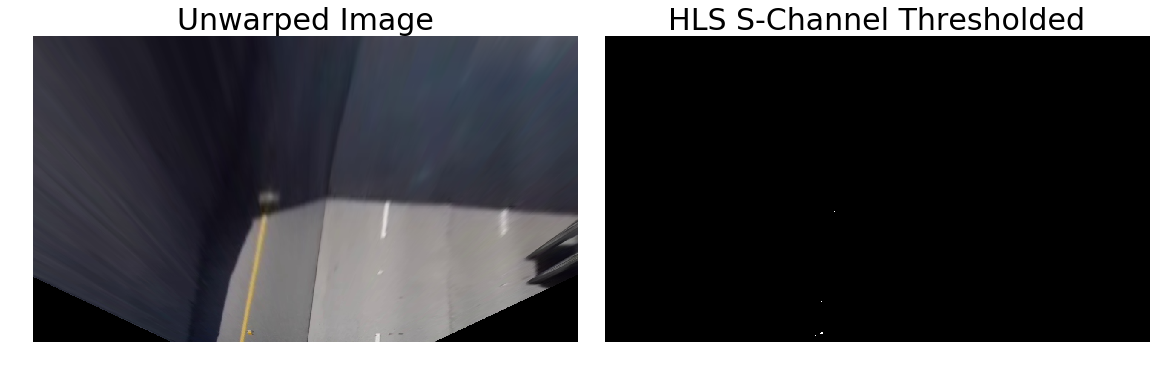

In [15]:
exampleImg_SThresh = hls_sthresh(exampleImg_unwarp)
# Visualize hls s-channel threshold
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(exampleImg_unwarp)
ax1.set_title('Unwarped Image', fontsize=30)
ax1.axis('off')
ax2.imshow(exampleImg_SThresh, cmap='gray')
ax2.set_title('HLS S-Channel Thresholded', fontsize=30)
ax2.axis('off')
    
print('...')

Definiranje funkcije za HLS l-kanal threshold i ispisivanje rezultata na slici

In [16]:
# Defining a function that thresholds the L-channel of HLS
def hls_lthresh(img, thresh=(220, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hls_l = hls[:,:,1]
    hls_l = hls_l*(255/np.max(hls_l))
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(hls_l)
    binary_output[(hls_l > thresh[0]) & (hls_l <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

print('...')

...


...


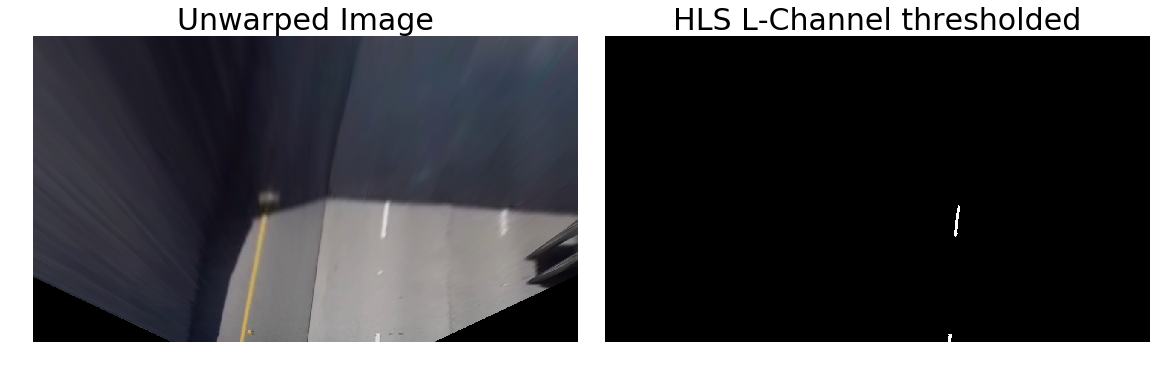

In [17]:
exampleImg_LThresh = hls_lthresh(exampleImg_unwarp)
# Visualize hls l-channel threshold
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(exampleImg_unwarp)
ax1.set_title('Unwarped Image', fontsize=30)
ax1.axis('off')
ax2.imshow(exampleImg_LThresh, cmap='gray')
ax2.set_title('HLS L-Channel thresholded', fontsize=30)
ax2.axis('off')   
print('...')

Definiranje funkcije za LAB B-kanal threshold i ispisivanje rezultata na slici

In [18]:
def lab_bthresh(img, thresh=(200,255)):
    # 1) Convert to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    lab_b = lab[:,:,2]
    # don't normalize if there are no yellows in the image
    if np.max(lab_b) > 175:
        lab_b = lab_b*(255/np.max(lab_b))
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(lab_b)
    binary_output[((lab_b > thresh[0]) & (lab_b <= thresh[1]))] = 1
    # 3) Return a binary image of threshold result
    return binary_output

...


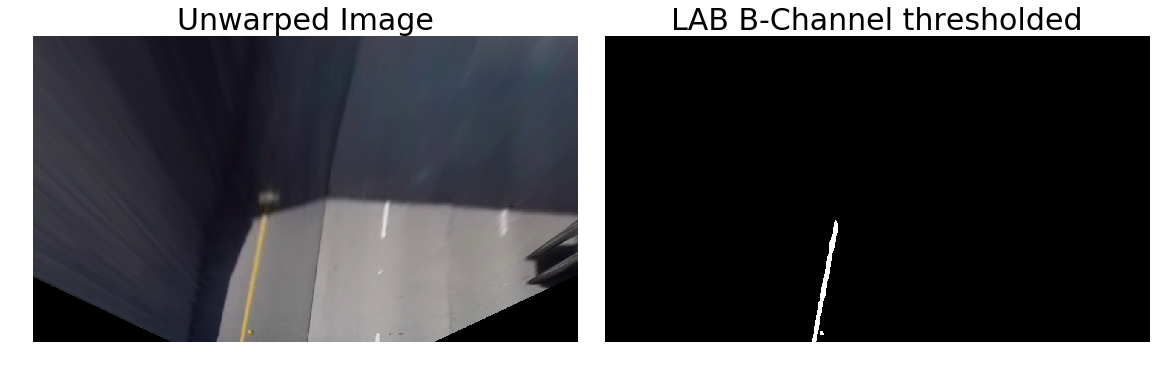

In [19]:
exampleImg_BThresh = lab_bthresh(exampleImg_unwarp)
# Visualizing hls l-channel threshold
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(exampleImg_unwarp)
ax1.set_title('Unwarped Image', fontsize=30)
ax1.axis('off')
ax2.imshow(exampleImg_BThresh, cmap='gray')
ax2.set_title('LAB B-Channel thresholded', fontsize=30)
ax2.axis('off')   
print('...')

Definiranje funkcije za LAB L-kanal threshold i ispisivanje rezultata na slici

In [20]:
def lab_lthresh(img, thresh=(190,255)):
    # 1) Convert to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    lab_b = lab[:,:,0]
    # don't normalize if there are no yellows in the image
    if np.max(lab_b) > 175:
        lab_b = lab_b*(255/np.max(lab_b))
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(lab_b)
    binary_output[((lab_b > thresh[0]) & (lab_b <= thresh[1]))] = 1
    # 3) Return a binary image of threshold result
    return binary_output

...


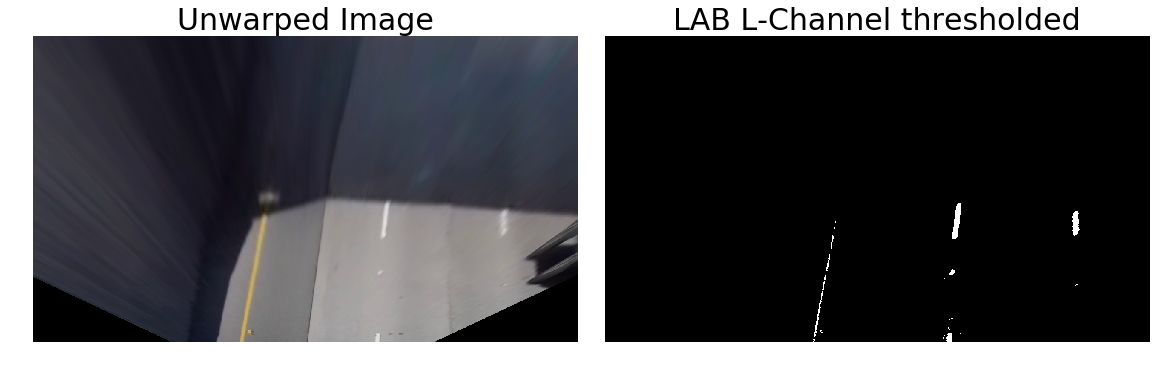

In [21]:
exampleImg_LLThresh = lab_lthresh(exampleImg_unwarp)
# Visualizing hls l-channel threshold
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(exampleImg_unwarp)
ax1.set_title('Unwarped Image', fontsize=30)
ax1.axis('off')
ax2.imshow(exampleImg_LLThresh, cmap='gray')
ax2.set_title('LAB L-Channel thresholded', fontsize=30)
ax2.axis('off')   
print('...')

Definiranje funkcije za RGB R,B,G-kanal threshold i ispisivanje rezultata na slici

In [22]:
def rgb_thresh(img, thresh=(200, 255), color = 0):
    # 1) Convert to HLS color space
    #rgb = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    binary_output = np.zeros_like(img[:,:,color])
    binary_output[(img[:,:,color] > thresh[0]) & (img[:,:,color] <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

...


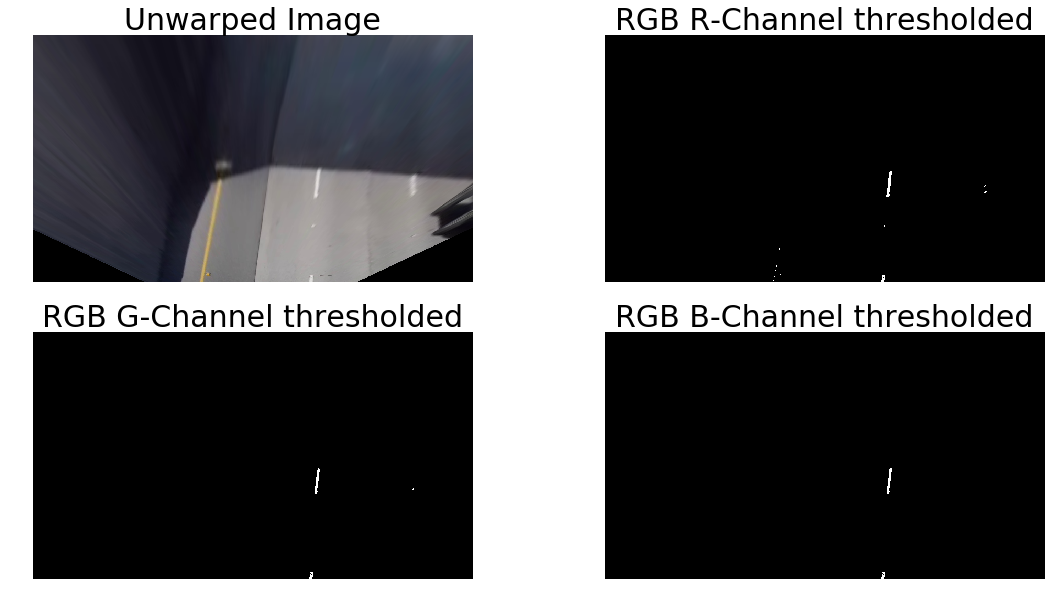

In [23]:
exampleImg_R_RGBThresh = rgb_thresh(exampleImg_unwarp,color=0)
exampleImg_G_RGBThresh = rgb_thresh(exampleImg_unwarp,color=1)
exampleImg_B_RGBThresh = rgb_thresh(exampleImg_unwarp,color=2)
# Visualize hls l-channel threshold
f, ax = plt.subplots(2, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax[0,0].imshow(exampleImg_unwarp)
ax[0,0].set_title('Unwarped Image', fontsize=30)
ax[0,0].axis('off')

ax[0,1].imshow(exampleImg_R_RGBThresh, cmap='gray')
ax[0,1].set_title('RGB R-Channel thresholded', fontsize=30)
ax[0,1].axis('off')

ax[1,0].imshow(exampleImg_G_RGBThresh, cmap='gray')
ax[1,0].set_title('RGB G-Channel thresholded', fontsize=30)
ax[1,0].axis('off')

ax[1,1].imshow(exampleImg_B_RGBThresh, cmap='gray')
ax[1,1].set_title('RGB B-Channel thresholded', fontsize=30)
ax[1,1].axis('off')

print('...')

Pravljenje 2D histograma svih izracunatih maski

...


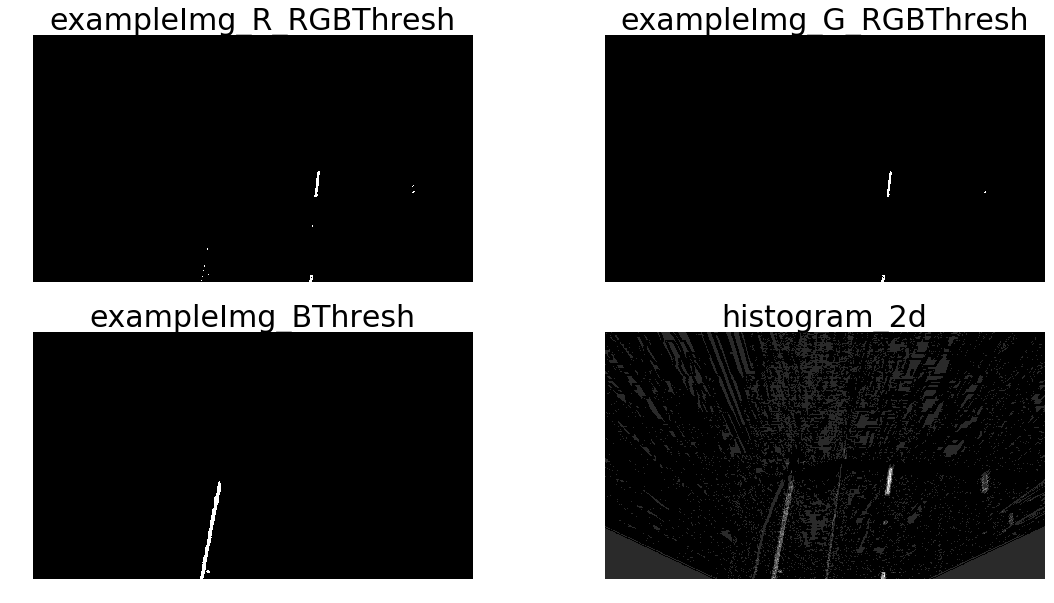

In [70]:
# create data
#histogram_2d = np.zeros_like(exampleImg_unwarp[:,:,0])

histogram_2d=exampleImg_sobelAbs+exampleImg_sobelDir+exampleImg_R_RGBThresh+exampleImg_G_RGBThresh+exampleImg_BThresh+exampleImg_LThresh+exampleImg_LLThresh+exampleImg_SThresh
# print(histogram_2d)
# print(histogram_2d.shape) 

#plt.hist2d(x, y, bins=(50, 50), cmap=plt.cm.jet)

# Visualize hls l-channel threshold
f, ax = plt.subplots(2, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax[0,0].imshow(exampleImg_R_RGBThresh, cmap='gray')
ax[0,0].set_title('exampleImg_R_RGBThresh', fontsize=30)
ax[0,0].axis('off')

ax[0,1].imshow(exampleImg_G_RGBThresh, cmap='gray')
ax[0,1].set_title('exampleImg_G_RGBThresh', fontsize=30)
ax[0,1].axis('off')

ax[1,0].imshow(exampleImg_BThresh, cmap='gray')
ax[1,0].set_title('exampleImg_BThresh', fontsize=30)
ax[1,0].axis('off')

ax[1,1].imshow(histogram_2d, cmap='gray')
ax[1,1].set_title('histogram_2d', fontsize=30)
ax[1,1].axis('off')
# plt.hexbin(histogram_2d)

#ax[1,1].imshow()
# ax[1,1].set_title('RGB B-Channel thresholded', fontsize=30)
# ax[1,1].axis('off')

print('...')

Kombiniranje dobivenih maska

In [25]:
sobelMag_sobelDir = np.zeros_like(exampleImg_sobelMag)
sobelMag_sobelDir[((exampleImg_sobelMag == 1) & (exampleImg_sobelDir == 1))] = 1

sobelAbs_sobelDir = np.zeros_like(exampleImg_sobelAbs)
sobelAbs_sobelDir[((exampleImg_sobelAbs == 1) & (exampleImg_sobelDir == 1))] = 1

sobelMag_sobelAbs = np.zeros_like(exampleImg_sobelMag)
sobelMag_sobelAbs[((exampleImg_sobelMag == 1) & (exampleImg_sobelAbs == 1))] = 1

combined_HLSl_LABb = np.zeros_like(exampleImg_BThresh)
combined_HLSl_LABb[((exampleImg_BThresh == 1) | (exampleImg_LThresh == 1))] = 1

combined_HLSs_LABb = np.zeros_like(exampleImg_SThresh)
combined_HLSs_LABb[((exampleImg_BThresh == 1) | (exampleImg_SThresh == 1))] = 1

combined_HLSl_SOBELabs = np.zeros_like(exampleImg_LThresh)
combined_HLSl_SOBELabs[((exampleImg_LThresh==1)|(exampleImg_sobelAbs==1))]=1

combined_HLSl_SOBELmag = np.zeros_like(exampleImg_LThresh)
combined_HLSl_SOBELmag[((exampleImg_LThresh==1)|(exampleImg_sobelMag==1))]=1

combined_HLSl_HLSs = np.zeros_like(exampleImg_LThresh)
combined_HLSl_HLSs[((exampleImg_LThresh==1)|(exampleImg_SThresh==1))]=1

combined_LABl_HLSs = np.zeros_like(exampleImg_LLThresh)
combined_LABl_HLSs[((exampleImg_LLThresh==1)|(exampleImg_SThresh==1))]=1


...


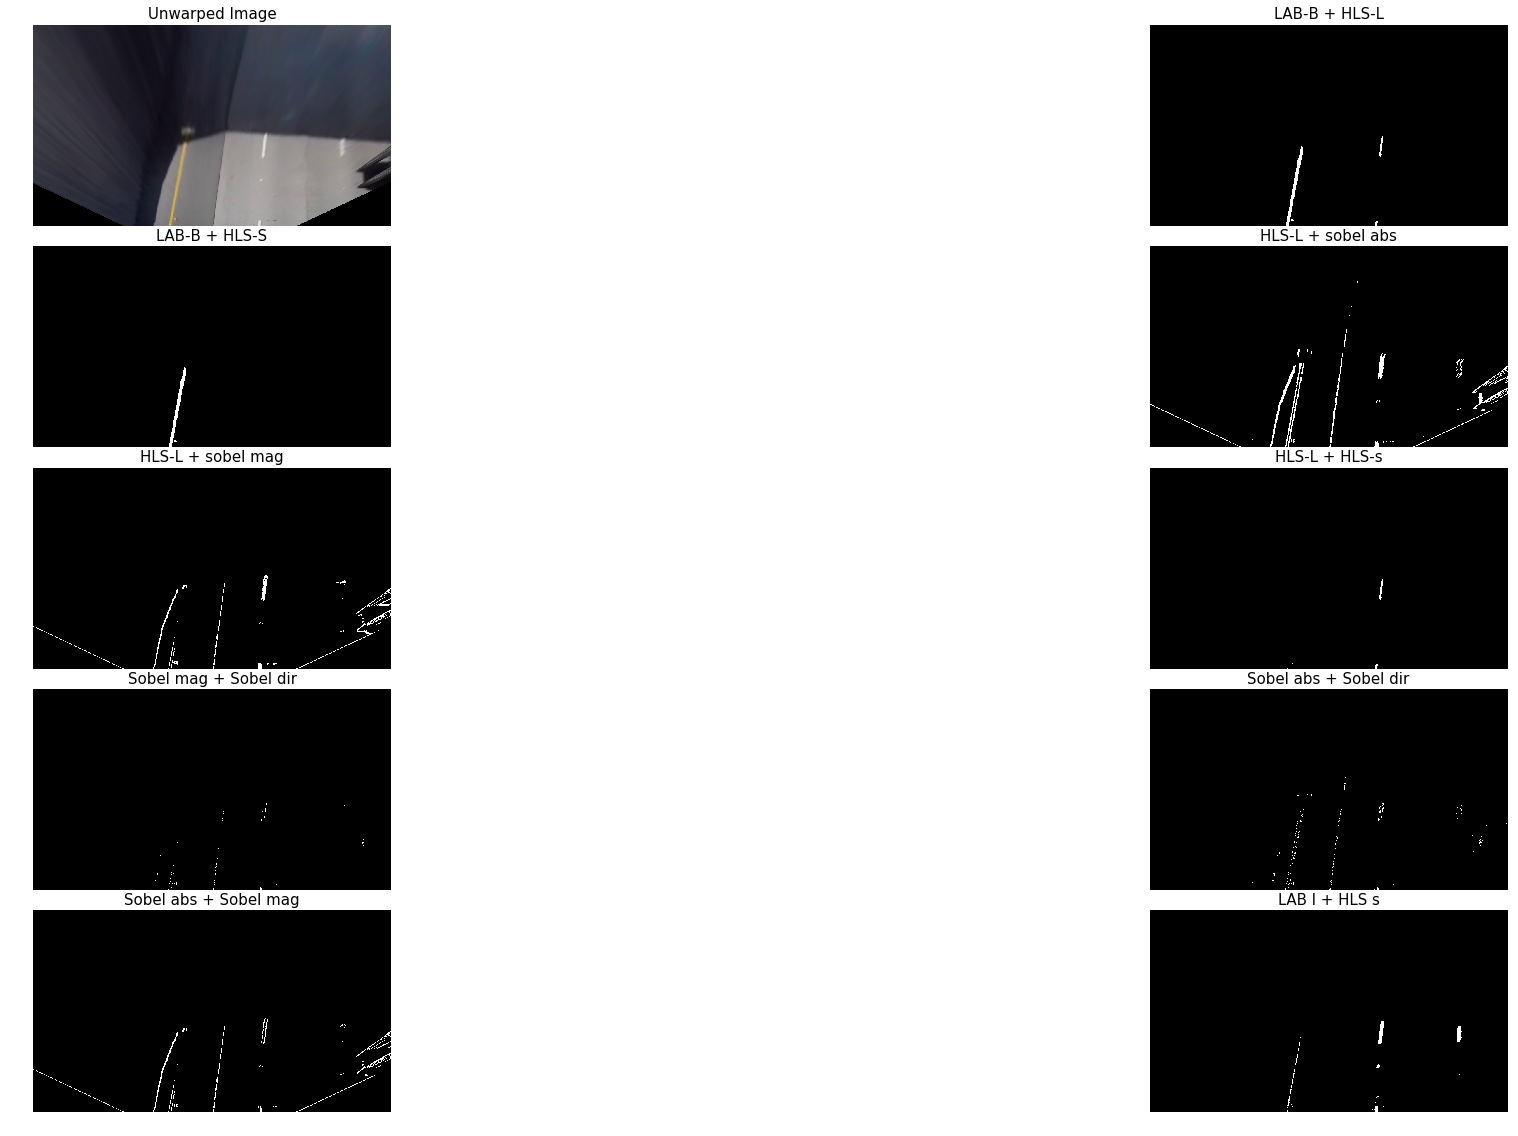

In [26]:
ff, axx = plt.subplots(5, 2, figsize=(40,20))
ff.subplots_adjust(hspace = .1, wspace=0.001)

axx[0,0].imshow(exampleImg_unwarp)
axx[0,0].axis('off')
axx[0,0].set_title('Unwarped Image', fontsize=15)

axx[0,1].imshow(combined_HLSl_LABb,cmap='gray')
axx[0,1].axis('off')
axx[0,1].set_title('LAB-B + HLS-L', fontsize=15)

axx[1,0].imshow(combined_HLSs_LABb,cmap='gray')
axx[1,0].axis('off')
axx[1,0].set_title('LAB-B + HLS-S', fontsize=15)

axx[1,1].imshow(combined_HLSl_SOBELabs,cmap='gray')
axx[1,1].axis('off')
axx[1,1].set_title('HLS-L + sobel abs', fontsize=15)

axx[2,0].imshow(combined_HLSl_SOBELmag,cmap='gray')
axx[2,0].axis('off')
axx[2,0].set_title('HLS-L + sobel mag', fontsize=15)

axx[2,1].imshow(combined_HLSl_HLSs,cmap='gray')
axx[2,1].axis('off')
axx[2,1].set_title('HLS-L + HLS-s', fontsize=15)

axx[3,0].imshow(sobelMag_sobelDir,cmap='gray')
axx[3,0].axis('off')
axx[3,0].set_title('Sobel mag + Sobel dir', fontsize=15)

axx[3,1].imshow(sobelAbs_sobelDir,cmap='gray')
axx[3,1].axis('off')
axx[3,1].set_title('Sobel abs + Sobel dir', fontsize=15)

axx[4,0].imshow(sobelMag_sobelAbs,cmap='gray')
axx[4,0].axis('off')
axx[4,0].set_title('Sobel abs + Sobel mag', fontsize=15)

axx[4,1].imshow(combined_LABl_HLSs,cmap='gray')
axx[4,1].axis('off')
axx[4,1].set_title('LAB l + HLS s', fontsize=15)

print('...')

Od dobivenih binarnih slika uzimamo jednu te ju dalje prosljeđujemo u sljedeći dio algoritma

Definiranje obrade slike u pipeline funkciju

In [27]:
def pipeline(img):
    # Undistort
    img_undistort = undistort(img)
    
    # Perspective Transform
    img_unwarp, M, Minv = unwarp(img_undistort, src, dst)

    # Sobel Absolute (using default parameters)
    #img_sobelAbs = abs_sobel_thresh(img_unwarp)

    # Sobel Magnitude (using default parameters)
    #img_sobelMag = mag_thresh(img_unwarp)
    
    # Sobel Direction (using default parameters)
    #img_sobelDir = dir_thresh(img_unwarp)
    
    # HLS S-channel Threshold (using default parameters)
    img_SThresh = hls_sthresh(img_unwarp)

    # HLS L-channel Threshold (using default parameters)
    img_LThresh = hls_lthresh(img_unwarp)
    
    # Lab L-channel Threshold (using default parameters)
    img_LLThresh = lab_lthresh(img_unwarp)

    # Lab B-channel Threshold (using default parameters)
    img_BThresh = lab_bthresh(img_unwarp)
    
    # Combine HLS and Lab B channel thresholds
    combined = np.zeros_like(img_BThresh)
    #combined[(img_LThresh == 1) | (img_BThresh == 1)] = 1
    combined[(img_SThresh == 1) | (img_LLThresh == 1)] = 1
    return combined, Minv

#  2. Obrada binarne slike nakon koje dobijemo dva pravca koja predstavljaju vozne trake

Uzimamo binarnu sliku i radimo histogram po x osi

...


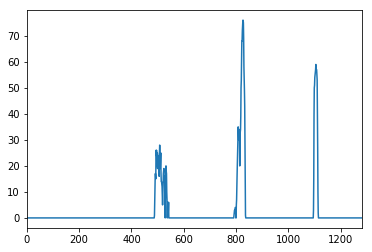

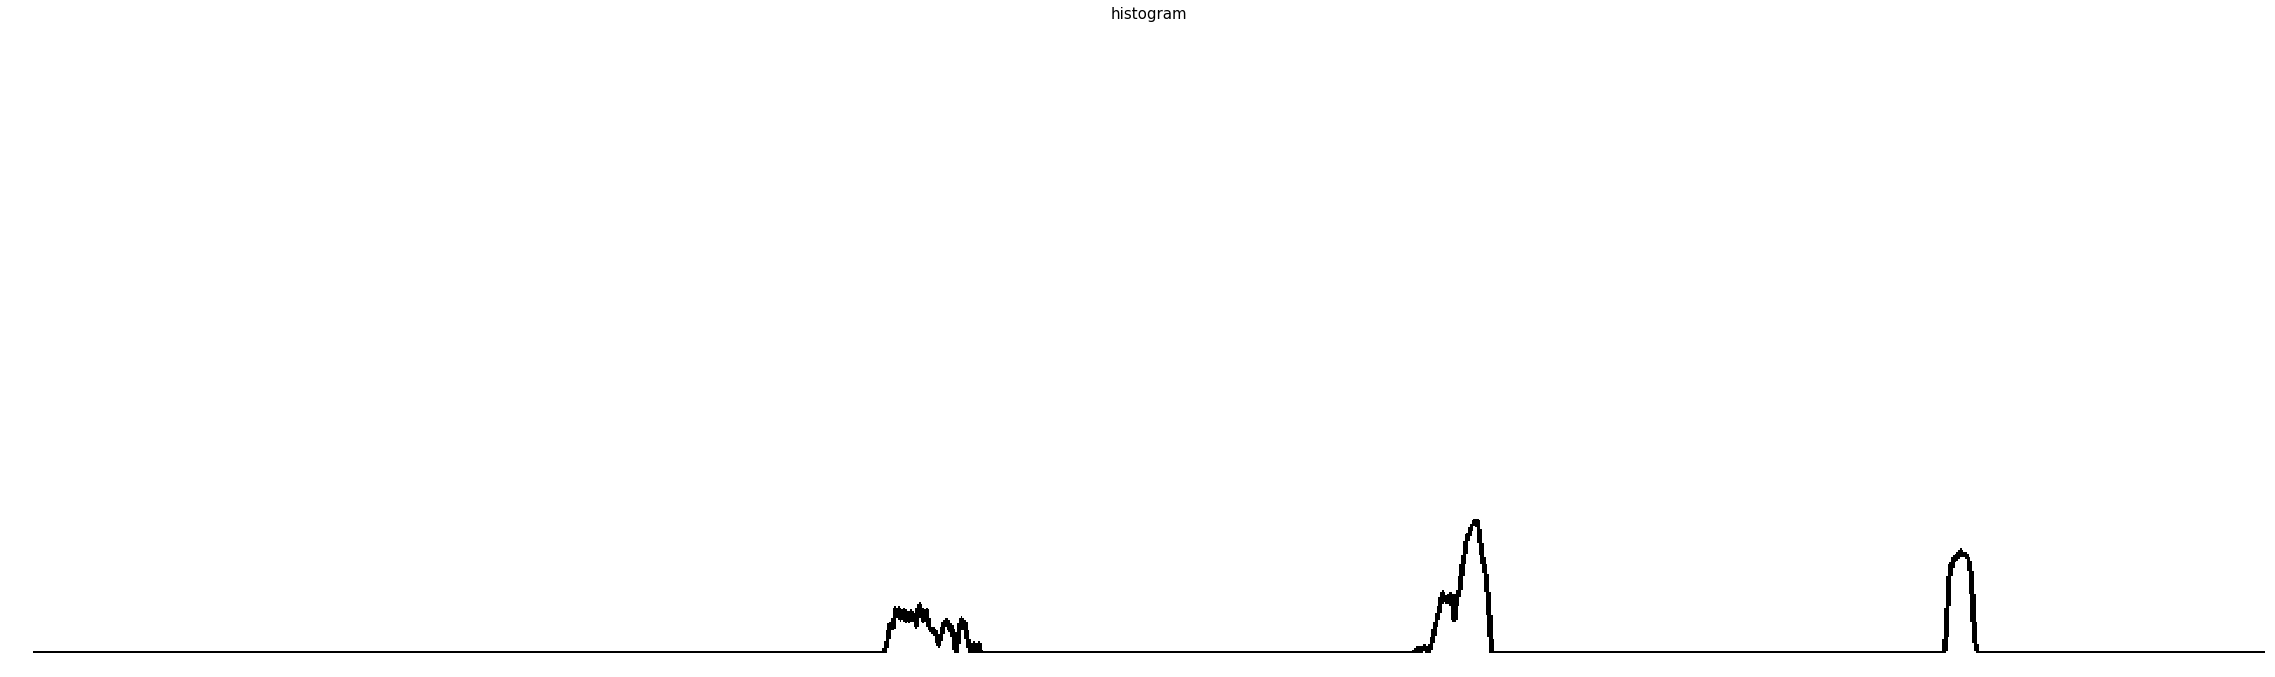

In [28]:
binary_image=combined_LABl_HLSs

histogram = np.sum(binary_image[binary_image.shape[0]//2:,:], axis=0)

plt.plot(histogram)
plt.xlim(0, 1280)

histogram_image=np.ones((binary_image.shape[0]//2,binary_image.shape[1]),dtype=int)
out_image = np.uint8(np.dstack((histogram_image, histogram_image, histogram_image))*255)
i=1
while i <= len(histogram)-1:
    cv2.line(out_image,(i-1,histogram_image.shape[0]-int(histogram[i-1])),(i,histogram_image.shape[0]-int(histogram[i])),(0,0,0),2)
    i+=1
    
ff, axx = plt.subplots(1, figsize=(40,20))
ff.subplots_adjust(hspace = .1, wspace=0.001)
axx.imshow(out_image,cmap='gray')
axx.axis('off')
axx.set_title('histogram', fontsize=15)

print('...')

Zatim pomoću histograma uzimamo 2 pozicije koje imaju najveću vrijednost
tj. položaje gdje ima najviše bijelih točaka na binarnoj slici po x osi

Uz to definiramo sve varijable potrebne za izračune

In [29]:
#finding the middle point of histogram
midpoint = np.int(histogram.shape[0]//2)
#finding the quarter of histogram
quarter_point = np.int(midpoint//2)
    
#with middle and quarter point, make left and right base positions
# leftx_base = np.argmax(histogram[quarter_point:midpoint]) + quarter_point
# rightx_base = np.argmax(histogram[midpoint:(midpoint+quarter_point)]) + midpoint

midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Number of sliding windows
nwindows = 9
# Height of windows
window_height = np.int(binary_image.shape[0]/nwindows)
    
# Identifing the x and y positions of all nonzero pixels in the image
nonzero = binary_image.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])   

# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base

# Set the width of the windows +/- margin
margin = 100

# Set minimum number of pixels found to recenter window
minpix = 40

# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []
# Rectangle data for visualization
rectangle_data = []

Određujemo sliku i pronalazimo na obje polovice slike (po x osi) dvije vrijednosti gdje ima najviše bijelih piksela i crtamo prozore (pravokutnike) oko tih vrijednosti.

Uz to računamo i mijenjamo (pomičemo) x i y koordinate prozora ako u prozoru postoji broj bijelih točaka veći od minpix. Pomičemo u lijevo ili desno pomoću određivanja srednje vrijednosti.

...


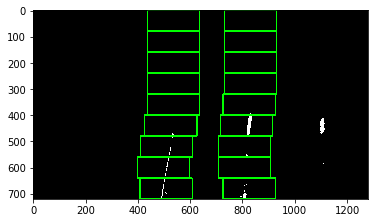

In [30]:
out_img=np.copy(binary_image)
out_img = np.uint8(np.dstack((binary_image, binary_image, binary_image))*255)

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_image.shape[0] - (window+1)*window_height
    win_y_high = binary_image.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3)
    rectangle_data.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))

    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        
        
 
plt.imshow(out_img)
print('...')

Nakon što smo pronašli sve piksele u prozoru koji su bijeli (1), dodajemo ih na liste.
Nakon toga pravimo polinom 2. stupnja od svih piksela unutar liste

In [31]:
# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

left_fit, right_fit = (None, None)
# Fit a second order polynomial to each
if len(leftx) != 0:
    left_fit = np.polyfit(lefty, leftx, 2)
if len(rightx) != 0:
    right_fit = np.polyfit(righty, rightx, 2)

visualization_data = (rectangle_data, histogram)

Crtamo polinome i označavamo detektirane linije crvenom (lijeva linija) i plavom (desna linija) bojom.

...


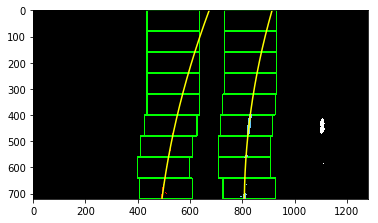

In [32]:
h = binary_image.shape[0]
left_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
right_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]

rectangles = visualization_data[0]
histogram = visualization_data[1]

ploty = np.linspace(0, binary_image.shape[0]-1, binary_image.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

nonzero = binary_image.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [100, 200, 255]


plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
print('...')

Stavljamo sve u funkciju

In [33]:
def sliding_window_polyfit(img):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    quarter_point = np.int(midpoint//2)
    # Previously the left/right base was the max of the left/right half of the histogram
    # this changes it so that only a quarter of the histogram (directly to the left/right) is considered
    leftx_base = np.argmax(histogram[quarter_point:midpoint]) + quarter_point
    rightx_base = np.argmax(histogram[midpoint:(midpoint+quarter_point)]) + midpoint
    
    #print('base pts:', leftx_base, rightx_base)

    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Rectangle data for visualization
    rectangle_data = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        rectangle_data.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    visualization_data = (rectangle_data, histogram)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data
print('...')

...


Ne moramo uvijek koristiti metodu iznad za određivanje polinoma. Možemo koristiti prethodno izračunate vrijednosti uz pretpostavku da se frame neće promijeniti previše naspram prethodnog. Zato definiramo funkciju kojoj predajemo novi frame, i prethodno izračunate koeficijente te ih pokušavamo spojiti s novom slikom.

In [34]:
 def polyfit_using_prev_fit(binary_warped, left_fit_prev, right_fit_prev):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] - margin)) & 
                      (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] - margin)) & 
                       (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit_new, right_fit_new = (None, None)
    if len(leftx) != 0:
        # Fit a second order polynomial to each
        left_fit_new = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty, rightx, 2)
    return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds
print('...')

...


Prikaz izračuna obje funkcije 

...


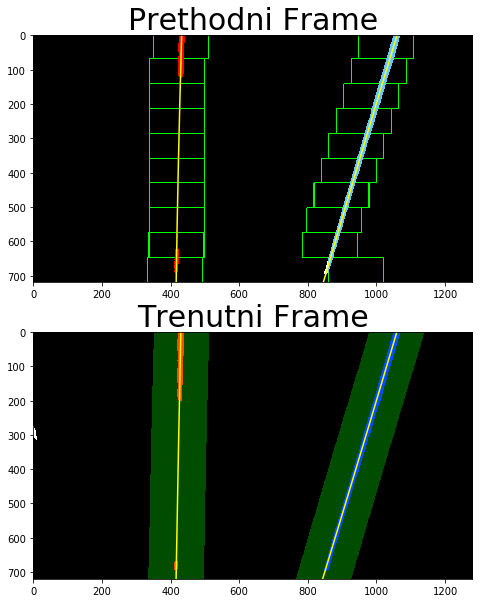

In [35]:
exampleImg = cv2.imread('./Test_images/dashcam_driving/frame288.jpg')
exampleImg = cv2.cvtColor(exampleImg, cv2.COLOR_BGR2RGB)
exampleImg_bin, Minv = pipeline(exampleImg)

exampleImg2 = cv2.imread('./Test_images/dashcam_driving/frame289.jpg')
exampleImg2 = cv2.cvtColor(exampleImg2, cv2.COLOR_BGR2RGB)
exampleImg2_bin, Minv = pipeline(exampleImg2)   
margin = 80

left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data = sliding_window_polyfit(exampleImg_bin)

left_fit2, right_fit2, left_lane_inds2, right_lane_inds2 = polyfit_using_prev_fit(exampleImg2_bin, left_fit, right_fit)

# Generate x and y values for plotting
ploty = np.linspace(0, exampleImg2_bin.shape[0]-1, exampleImg2_bin.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
left_fitx2 = left_fit2[0]*ploty**2 + left_fit2[1]*ploty + left_fit2[2]
right_fitx2 = right_fit2[0]*ploty**2 + right_fit2[1]*ploty + right_fit2[2]

# Create an image to draw on and an image to show the selection window
out_img = np.uint8(np.dstack((exampleImg2_bin, exampleImg2_bin, exampleImg2_bin))*255)
window_img = np.zeros_like(out_img)

# Color in left and right line pixels
nonzero = exampleImg2_bin.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds2], nonzerox[left_lane_inds2]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds2], nonzerox[right_lane_inds2]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area (OLD FIT)
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)


# Create an output image to draw on and  visualize the result
out_img2 = np.uint8(np.dstack((exampleImg_bin, exampleImg_bin, exampleImg_bin))*255)
rectangles = visualization_data[0]
histogram = visualization_data[1]
for rect in rectangles:
# Draw the windows on the visualization image
    cv2.rectangle(out_img2,(rect[2],rect[0]),(rect[3],rect[1]),(0,255,0), 2) 
    cv2.rectangle(out_img2,(rect[4],rect[0]),(rect[5],rect[1]),(0,255,0), 2) 
    

nonzero = exampleImg_bin.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img2[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img2[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [100, 200, 255]
    
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)


ax1.imshow(out_img2)
ax1.plot(left_fitx, ploty, color='yellow')
ax1.plot(right_fitx, ploty, color='yellow')
ax1.set_title('Prethodni Frame', fontsize=30)

ax2.imshow(result)
ax2.plot(left_fitx2, ploty, color='yellow')
ax2.plot(right_fitx2, ploty, color='yellow')
ax2.set_title('Trenutni Frame', fontsize=30)

print('...')

Definiramo funkciju u kojoj izračunavamo radijus krivulja (linija) i udaljenost od središta između linija.

In [36]:
# Method to determine radius of curvature and distance from lane center 
# based on binary image, polynomial fit, and L and R lane pixel indices
def calc_curv_rad_and_center_dist(bin_img, l_fit, r_fit, l_lane_inds, r_lane_inds):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 3.048/100 # meters per pixel in y dimension, lane line is 10 ft = 3.048 meters
    xm_per_pix = 3.7/378 # meters per pixel in x dimension, lane width is 12 ft = 3.7 meters
    left_curverad, right_curverad, center_dist = (0, 0, 0)
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    h = bin_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    y_eval = np.max(ploty)
  
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = bin_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Again, extract left and right line pixel positions
    leftx = nonzerox[l_lane_inds]
    lefty = nonzeroy[l_lane_inds] 
    rightx = nonzerox[r_lane_inds]
    righty = nonzeroy[r_lane_inds]
    
    if len(leftx) != 0 and len(rightx) != 0:
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
    
    # Distance from center is image x midpoint - mean of l_fit and r_fit intercepts 
    if r_fit is not None and l_fit is not None:
        car_position = bin_img.shape[1]/2
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix
    return left_curverad, right_curverad, center_dist
print('...')



...


In [37]:
rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(exampleImg_bin, left_fit, right_fit, left_lane_inds, right_lane_inds)

print('Radius of curvature for example:', rad_l, 'm,', rad_r, 'm')
print('Distance from lane center for example:', d_center, 'm')

Radius of curvature for example: 4948.205868412435 m, 5273.471751156028 m
Distance from lane center for example: 0.08975860264330247 m


Definiranje funkcije u kojoj vračamo izračunate krivulje na originalnu sliku. 

In [38]:
def draw_lane(original_img, binary_img, l_fit, r_fit, Minv):
    new_img = np.copy(original_img)
    if l_fit is None or r_fit is None:
        return original_img
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = binary_img.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result
print('...')

...


...


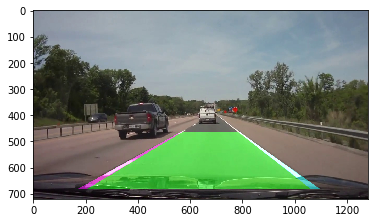

In [39]:
exampleImg_out1 = draw_lane(exampleImg, exampleImg_bin, left_fit, right_fit, Minv)
plt.imshow(exampleImg_out1)
print('...')

Definiramo funkciju koja ispisuje izračunate vrijednosti na originalnu sliku.

In [40]:
def draw_data(original_img, curv_rad, center_dist):
    new_img = np.copy(original_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img
print('...')

...


...


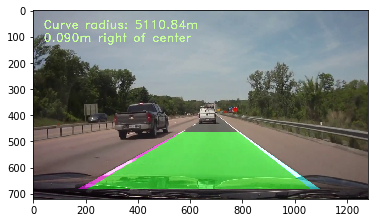

In [41]:
exampleImg_out2 = draw_data(exampleImg_out1, (rad_l+rad_r)/2, d_center)
plt.imshow(exampleImg_out2)
print('...')

Stvaranje klase Line (linija) koja sadrži sve potrebno za izračun linije.

In [42]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #number of detected pixels
        self.px_count = None
    def add_fit(self, fit, inds):
        # add a found fit to the line, up to n
        if fit is not None:
            if self.best_fit is not None:
                # if we have a best fit, see how this new fit compares
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or \
               self.diffs[1] > 1.0 or \
               self.diffs[2] > 100.) and \
               len(self.current_fit) > 0:
                # bad fit! abort! abort! ... well, unless there are no fits in the current_fit queue, then we'll take it
                self.detected = False
            else:
                self.detected = True
                self.px_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    # throw out old fits, keep newest n
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.best_fit = np.average(self.current_fit, axis=0)
        # or remove one from the history, if not found
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                # throw out oldest fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.current_fit, axis=0)


            

print('...')


...


Potpuni pipeline

In [43]:
def process_image(img):
    new_img = np.copy(img)
    img_bin, Minv = pipeline(new_img)
    
    # if both left and right lines were detected last frame, use polyfit_using_prev_fit, otherwise use sliding window
    if not l_line.detected or not r_line.detected:
        l_fit, r_fit, l_lane_inds, r_lane_inds, _ = sliding_window_polyfit(img_bin)
    else:
        l_fit, r_fit, l_lane_inds, r_lane_inds = polyfit_using_prev_fit(img_bin, l_line.best_fit, r_line.best_fit)
        
    # invalidate both fits if the difference in their x-intercepts isn't around 350 px (+/- 100 px)
    if l_fit is not None and r_fit is not None:
        # calculate x-intercept (bottom of image, x=image_height) for fits
        h = img.shape[0]
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        x_int_diff = abs(r_fit_x_int-l_fit_x_int)
        if abs(350 - x_int_diff) > 100:
            l_fit = None
            r_fit = None
            
    l_line.add_fit(l_fit, l_lane_inds)
    r_line.add_fit(r_fit, r_lane_inds)
    
    # draw the current best fit if it exists
    if l_line.best_fit is not None and r_line.best_fit is not None:
        img_out1 = draw_lane(new_img, img_bin, l_line.best_fit, r_line.best_fit, Minv)
        rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(img_bin, l_line.best_fit, r_line.best_fit, 
                                                               l_lane_inds, r_lane_inds)
        img_out = draw_data(img_out1, (rad_l+rad_r)/2, d_center)
    else:
        img_out = new_img
    
    diagnostic_output = False
    if diagnostic_output:
        # put together multi-view output
        diag_img = np.zeros((720,1280,3), dtype=np.uint8)
        
        # original output (top left)
        diag_img[0:360,0:640,:] = cv2.resize(img_out,(640,360))
        
        # binary overhead view (top right)
        img_bin = np.dstack((img_bin*255, img_bin*255, img_bin*255))
        resized_img_bin = cv2.resize(img_bin,(640,360))
        diag_img[0:360,640:1280, :] = resized_img_bin
        
        # overhead with all fits added (bottom right)
        img_bin_fit = np.copy(img_bin)
        for i, fit in enumerate(l_line.current_fit):
            img_bin_fit = plot_fit_onto_img(img_bin_fit, fit, (20*i+100,0,20*i+100))
        for i, fit in enumerate(r_line.current_fit):
            img_bin_fit = plot_fit_onto_img(img_bin_fit, fit, (0,20*i+100,20*i+100))
        img_bin_fit = plot_fit_onto_img(img_bin_fit, l_line.best_fit, (255,255,0))
        img_bin_fit = plot_fit_onto_img(img_bin_fit, r_line.best_fit, (255,255,0))
        diag_img[360:720,640:1280,:] = cv2.resize(img_bin_fit,(640,360))
        
        # diagnostic data (bottom left)
        color_ok = (200,255,155)
        color_bad = (255,155,155)
        font = cv2.FONT_HERSHEY_DUPLEX
        if l_fit is not None:
            text = 'This fit L: ' + ' {:0.6f}'.format(l_fit[0]) + \
                                    ' {:0.6f}'.format(l_fit[1]) + \
                                    ' {:0.6f}'.format(l_fit[2])
        else:
            text = 'This fit L: None'
        cv2.putText(diag_img, text, (40,380), font, .5, color_ok, 1, cv2.LINE_AA)
        if r_fit is not None:
            text = 'This fit R: ' + ' {:0.6f}'.format(r_fit[0]) + \
                                    ' {:0.6f}'.format(r_fit[1]) + \
                                    ' {:0.6f}'.format(r_fit[2])
        else:
            text = 'This fit R: None'
        cv2.putText(diag_img, text, (40,400), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Best fit L: ' + ' {:0.6f}'.format(l_line.best_fit[0]) + \
                                ' {:0.6f}'.format(l_line.best_fit[1]) + \
                                ' {:0.6f}'.format(l_line.best_fit[2])
        cv2.putText(diag_img, text, (40,440), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Best fit R: ' + ' {:0.6f}'.format(r_line.best_fit[0]) + \
                                ' {:0.6f}'.format(r_line.best_fit[1]) + \
                                ' {:0.6f}'.format(r_line.best_fit[2])
        cv2.putText(diag_img, text, (40,460), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Diffs L: ' + ' {:0.6f}'.format(l_line.diffs[0]) + \
                             ' {:0.6f}'.format(l_line.diffs[1]) + \
                             ' {:0.6f}'.format(l_line.diffs[2])
        if l_line.diffs[0] > 0.001 or \
           l_line.diffs[1] > 1.0 or \
           l_line.diffs[2] > 100.:
            diffs_color = color_bad
        else:
            diffs_color = color_ok
        cv2.putText(diag_img, text, (40,500), font, .5, diffs_color, 1, cv2.LINE_AA)
        text = 'Diffs R: ' + ' {:0.6f}'.format(r_line.diffs[0]) + \
                             ' {:0.6f}'.format(r_line.diffs[1]) + \
                             ' {:0.6f}'.format(r_line.diffs[2])
        if r_line.diffs[0] > 0.001 or \
           r_line.diffs[1] > 1.0 or \
           r_line.diffs[2] > 100.:
            diffs_color = color_bad
        else:
            diffs_color = color_ok
        cv2.putText(diag_img, text, (40,520), font, .5, diffs_color, 1, cv2.LINE_AA)
        text = 'Good fit count L:' + str(len(l_line.current_fit))
        cv2.putText(diag_img, text, (40,560), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Good fit count R:' + str(len(r_line.current_fit))
        cv2.putText(diag_img, text, (40,580), font, .5, color_ok, 1, cv2.LINE_AA)
        
        img_out = diag_img
    return img_out
print('...')

...


In [44]:
def plot_fit_onto_img(img, fit, plot_color):
    if fit is None:
        return img
    new_img = np.copy(img)
    h = new_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    plotx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
    pts = np.array([np.transpose(np.vstack([plotx, ploty]))])
    cv2.polylines(new_img, np.int32([pts]), isClosed=False, color=plot_color, thickness=8)
    return new_img
print('...')

...
